# Project: Analyzing NYC High School Data

# Introduction

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. 
This project aims to analyze New York City High School SAT Scores and to see if there is any factor that could impact to SAT and show it is unfair test.

# Read in the data

In [119]:
import os
os.getcwd()
os.chdir("D:\\PERSONAL\\CODING\\PROJECT\\NYC High School data")

In [120]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [121]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [122]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [123]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [124]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [125]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets


In [126]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [127]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [128]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [129]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

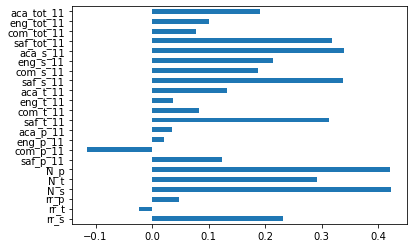

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.barh()

There are some factor that have negative correlation with SAT scores:

- Communication score based on parent responses
- Teacher Response Rate

There are some factors that have strong correlation with SAT scores:

- Student Response Rate
- Number of student, teacher, parents respondents
- Safety and Respect score based on teacher, parents and students. It sounds reasonable because students have support from teacher and parents
- Academic expectations score based on student responses but have low correlation with expectations from teacher and parents. It could make sense since the expection from teacher and parents can be a pressure to student

# Investigate safety and SAT scores

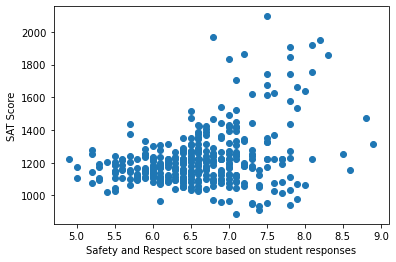

In [131]:
#Visualize safety score and SAT scores to see if they are have any correlation:
fig, ax= plt.subplots()
plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.xlabel("Safety and Respect score based on student responses")
plt.ylabel("SAT Score")
plt.show()

There is some positive correlation between Safety and Respect score based on student responses and SAT scores, however this is not strong one. There may be because of some of school have strong impacts and somes have low impact to this scores

In [132]:
#Compute safety scores:
combined["boro"].unique() #to see NYC has which borough
#The boroughs are: Manhattan, Bronx, Brooklyn, Queens, Staten Island
safety_score=combined.groupby("boro").agg(np.mean)["saf_s_11"]
safety_score

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

It seems that the safety score is same between each borough. So the reason of safety score is from school

# Explore Race and SAT Scores

New York has many immigrations so the race may be impact to SAT Scores. We will dig deep in to this factor to see if there is unfair in race that leads to high/low SAT scores or not

Text(0, 0.5, 'correlation between SAT scores and races')

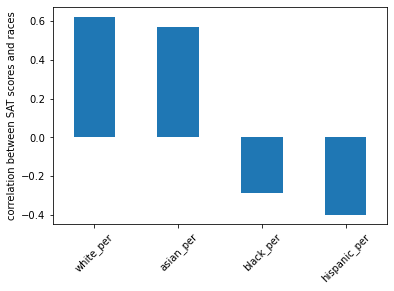

In [133]:
list=["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][list].plot.bar(rot=45)
plt.ylabel("correlation between SAT scores and races")

While white and Asian student have high SAT scores, the black and hispanic students has lower scores. Let's see how each race have correlation with SAT scores by visualizing scatter plot:

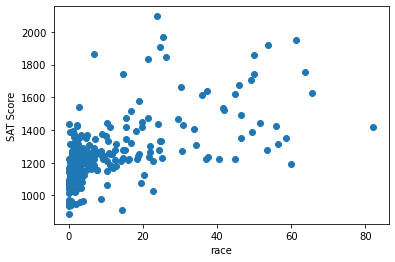

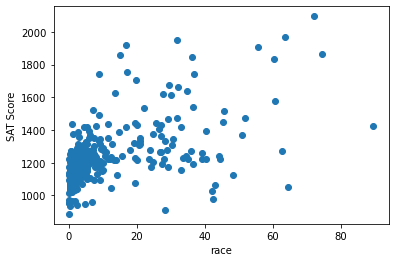

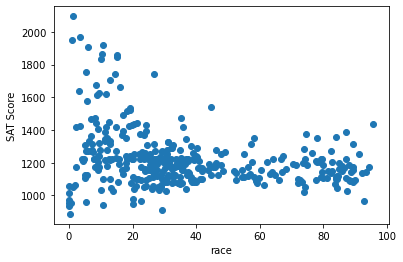

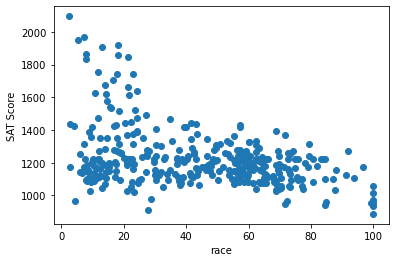

In [134]:
#White student with SAT scores
for race in list:
    plt.scatter(combined[race], combined["sat_score"])
    plt.xlabel("race")
    plt.ylabel("SAT Score")
    plt.show()

We can see that White and Asian students have positive correlation with SAT score while black and hispanic students have negative correlation.

In [135]:
popular_school_with_hispanic_student=combined[combined["hispanic_per"]>95]["SCHOOL NAME"]
popular_school_with_hispanic_student

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are international school where many international students study

In [136]:
school_with_unpopular_hispanic_student=combined[combined["hispanic_per"]<10]["SCHOOL NAME"]
school_with_unpopular_hispanic_student

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

These school are specialized school for excellent/elite student

# Gender and SAT Scores

Text(0, 0.5, 'correlation between SAT scores and gender')

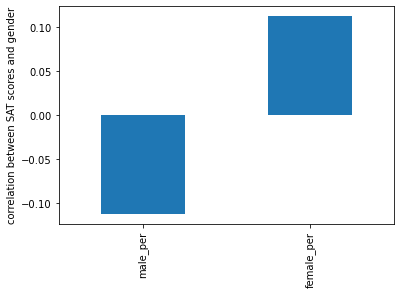

In [137]:
gender=["male_per", "female_per"]
combined.corr()["sat_score"][gender].plot.bar()
plt.ylabel("correlation between SAT scores and gender")

Female have positive correlation with SAT scores while Male have the opposite relation. Female may have higher score than male

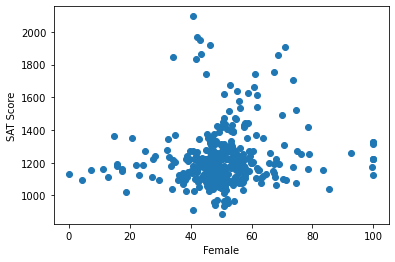

In [138]:
plt.scatter(combined["female_per"], combined["sat_score"])
plt.xlabel("Female")
plt.ylabel("SAT Score")
plt.show()

40-60% female have score from 100-1400

In [139]:
popular_female_school_with_high_score=combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"]
popular_female_school_with_high_score
                                                
                                             

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These school are also specialize and elite school that have competetive requirement to be accepted to school

# AP Score and SAT Scores

In [140]:
combined["ap_per"]=combined["AP Test Takers "]/ combined["total_enrollment"]
combined["ap_per"]

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

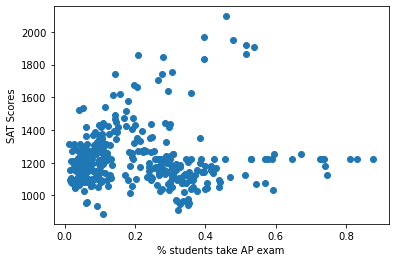

In [141]:
#make a scatter plot to see the relationship between AP scores and SAT Scores
plt.scatter(combined["ap_per"], combined["sat_score"])
plt.xlabel("% students take AP exam")
plt.ylabel("SAT Scores")
plt.show()

There is likely a relationship between the percentage of students in a school who take the AP exam and their average SAT scores, however it does not show the strong relationship

# Final conclusion:

Based on our analization, we could conclude:
- There is an unclear relationship between the safety, the borough, gender and AP Exam taker with their SAT scores
- There is different SAT Scores between White+Asian students with Black and Hispanic studens